# Imports

In [1]:
import datetime
import inflection
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import xgboost as xgb

from boruta import BorutaPy
from IPython.display import Image
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [17,5]
    plt.rcParams['font.size'] = 26

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set()

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name':model_name,
                         'MAE':mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

def cross_validation(x_training,kfold,model_name,model,verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        
        # Start and End date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date   = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)        
        
        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) &
                                (x_training['date'] <= validation_end_date)]
        
        # Training and validation dataset
        # training
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining,ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name,np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name':model_name,
                         'MAE CV':f"{round(np.mean(mae_list),2)} +/- {round(np.std(mae_list),2)}",
                         'MAPE CV':f"{round(np.mean(mape_list),2)} +/- {round(np.std(mape_list),2)}",
                         'RMSE CV':f"{round(np.mean(rmse_list),2)} +/- {round(np.std(rmse_list),2)}"},index=[0])

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Load Data

In [4]:
df_sales_raw = pd.read_csv('train.csv', low_memory=False)
df_store_raw = pd.read_csv('store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# Data Description

In [5]:
df1 = df_raw.copy()

## Rename columns

In [6]:
# Rename to snake case
df1.columns = list(
                   map(lambda x: inflection.underscore(x),
                       df1.columns)
                   )

## Data dimension

In [7]:
print(f'Number of rows: {len(df1.index)}',
      f'\nNumber of columns: {len(df1.columns)}')

Number of rows: 1017209 
Number of columns: 18


## Data types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [12]:
df1['competition_distance'].max()

75860.0

In [10]:
# Fills 'competition_distance' NAs with a number considerably larger than the current maximum value
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 500000 if math.isnan(x) else x)

In [11]:
# Fills NAs with the same month, year and week of 'date'
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month
                                                if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'],
                                                axis = 1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'],
                                                axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                                if math.isnan(x['promo2_since_week'])
                                                else x['promo2_since_week'],
                                                axis = 1)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['promo2_since_year'])
                                                else x['promo2_since_year'],
                                                axis = 1)

In [12]:
#promo_interval
df1['promo_interval'].fillna(0, inplace = True)

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo2'] = df1[['promo_interval', 'month_map']].apply(
    lambda x:
        0 if x['promo_interval'] == 0
        else
            1 if x['month_map'] in x['promo_interval'].split( ',' )
            else 0,
        axis=1 )

## Change types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## Descriptive Statistics

### Numerical Attributes

In [17]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
store,"1,017,209.00",558.43,321.91,1.00,280.00,558.00,838.00,"1,115.00"
day_of_week,"1,017,209.00",4.00,2.00,1.00,2.00,4.00,6.00,7.00
sales,"1,017,209.00","5,773.82","3,849.93",0.00,"3,727.00","5,744.00","7,856.00","41,551.00"
customers,"1,017,209.00",633.15,464.41,0.00,405.00,609.00,837.00,"7,388.00"
open,"1,017,209.00",0.83,0.38,0.00,1.00,1.00,1.00,1.00
promo,"1,017,209.00",0.38,0.49,0.00,0.00,0.00,1.00,1.00
school_holiday,"1,017,209.00",0.18,0.38,0.00,0.00,0.00,0.00,1.00
competition_distance,"1,017,209.00","6,714.63","26,325.29",20.00,710.00,"2,330.00","6,910.00","500,000.00"
competition_open_since_month,"1,017,209.00",6.79,3.31,1.00,4.00,7.00,10.00,12.00
competition_open_since_year,"1,017,209.00","2,010.32",5.52,"1,900.00","2,008.00","2,012.00","2,014.00","2,015.00"


### Categorical Attributes

In [18]:
df1.describe(include = ['object']).T

,count,unique,top,freq
state_holiday,1017209,4,0,986159
store_type,1017209,4,a,551627
assortment,1017209,3,a,537445
promo_interval,1017209,4,0,508031
month_map,1017209,12,May,103695


<AxesSubplot:xlabel='assortment', ylabel='sales'>

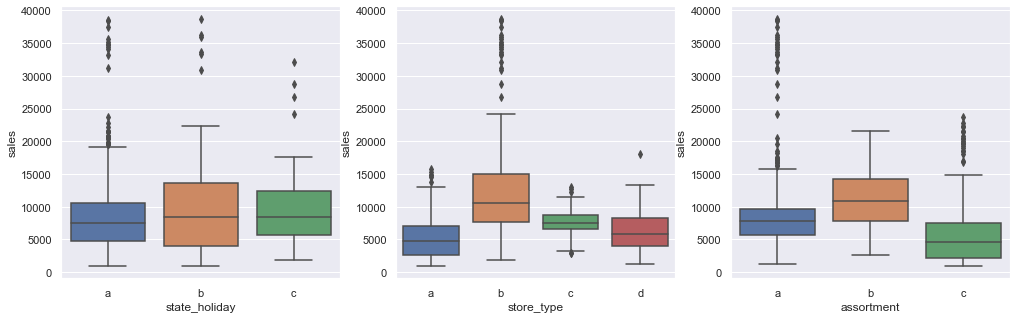

In [14]:
aux = df1[(df1['sales'] != 0) & (df1['state_holiday'] != '0')]

#plt.figure(figsize=(17,5))

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux, order = ['a', 'b', 'c'])

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux, order = ['a', 'b', 'c', 'd'])

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux, order = ['a', 'b', 'c'])
plt.show();

# Feature Engineering

In [15]:
df2 = df1.copy()

## Mind Map

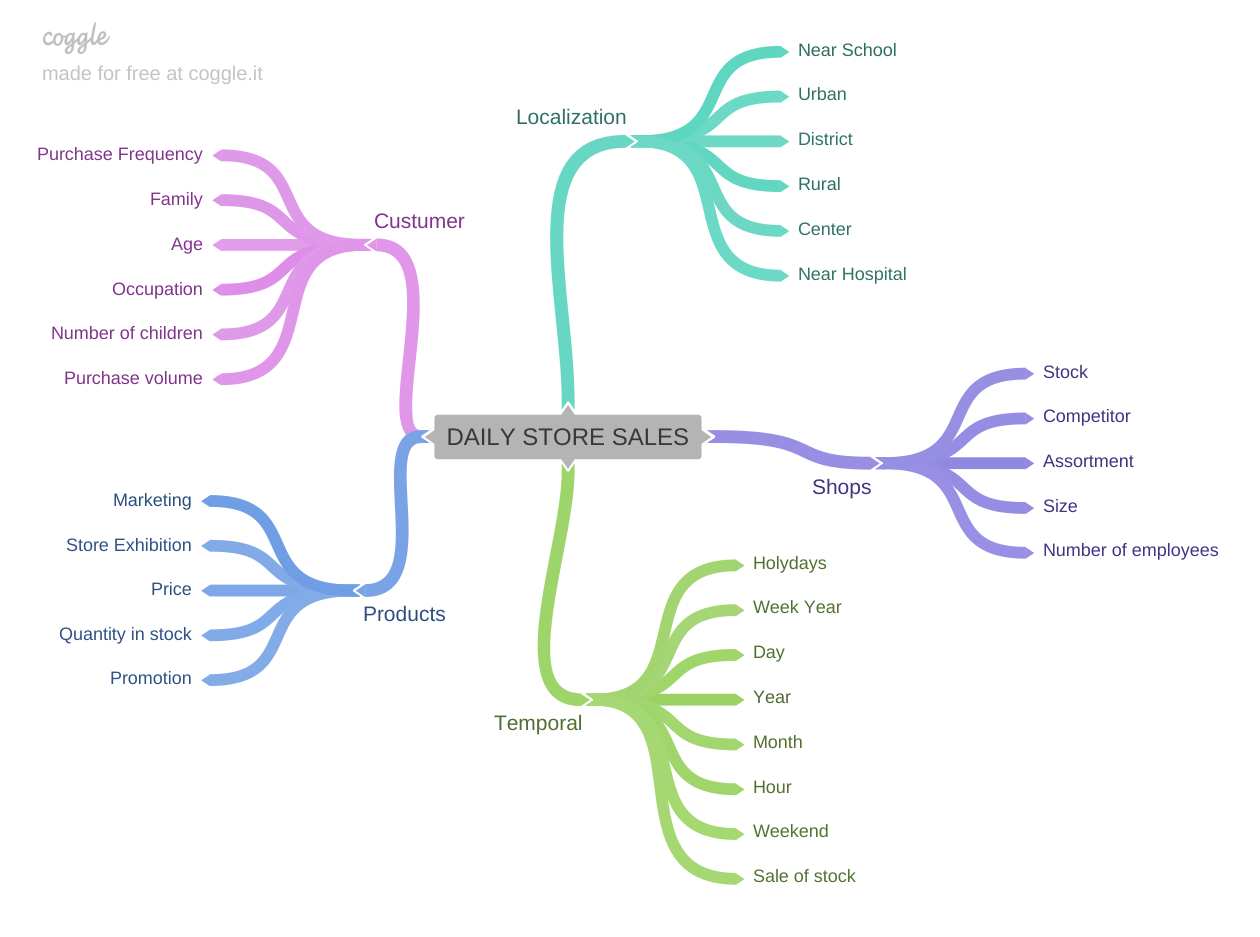

In [21]:
Image('mindmap.png')

## Hypothesis

**1.** Stores with a larger assortment should sell more

**2.** Stores with closer competitors should sell less

**3.** Stores with competitors for longer time should sell more

**4.** Stores with promotions active for longer should sell more

**5.** Stores with more days of promotions should sell more

**6.** Stores with more consecutive promotions should sell more

**7.** Stores open on Christmas holiday should sell more

**8.** Stores should sell more over the time

**9.** Stores should sell more in the second half of the year

**10.** Stores should sell more after the 10th day of each month

**11.** Stores should sell less on weekends

**12.** Stores should sell less during school holidays

## Feature Engineering

In [16]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week #weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x:
                                         datetime.datetime(year = x['competition_open_since_year'],
                                                           month = x['competition_open_since_month'],
                                                           day = 1),
                                         axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7)
)
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'
)

# Filters

In [17]:
df3 = df2.copy()

## Rows Filtering

In [18]:
df3 = df3[(df3['open']!= 0) & (df3['sales'] > 0)]

## Columns Selection

In [19]:
cols_drop = ['customers','open','promo_interval','month_map']

df3 = df3.drop(cols_drop, axis=1)

# EDA - Exploratory Data Analysis

In [20]:
df4 = df3.copy()

## Univariate Analysis

### Response Variable

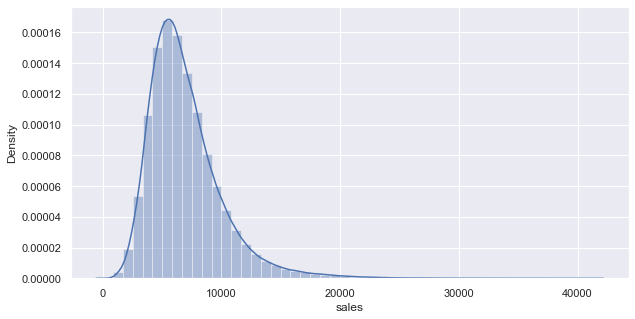

In [21]:
plt.rcParams['figure.figsize'] = [10,5]
sns.distplot(df4['sales']);

### Numerical Variable

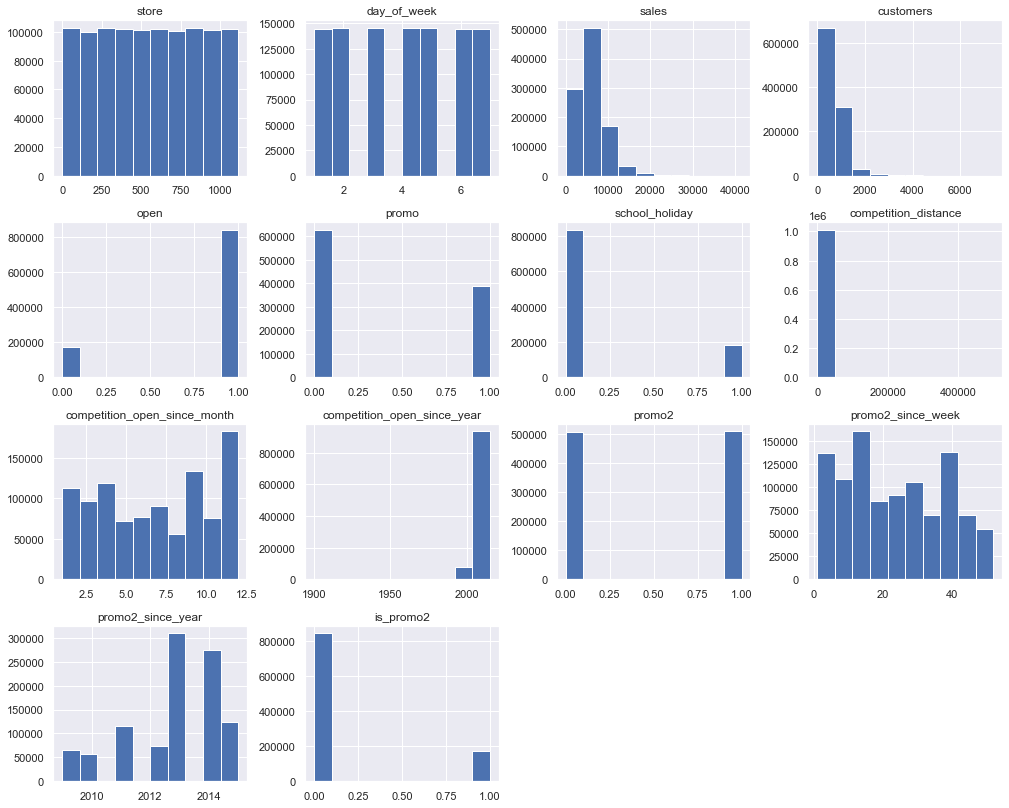

In [22]:
num_attributes = df1.select_dtypes(include=['int64' , 'float64'])
plt.rcParams['figure.figsize'] = [17,14]
num_attributes.hist();

### Categorical Variable

In [28]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

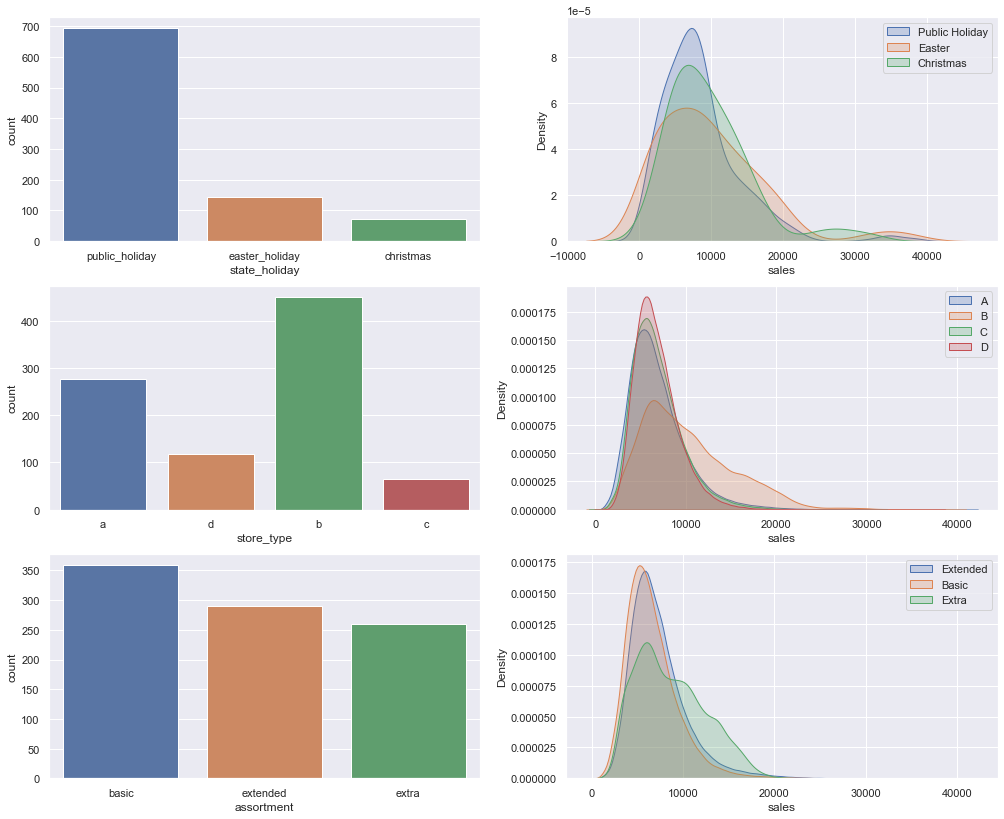

In [23]:
# state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
# sns.countplot(x='state_holiday',data=a) (Google Colab)

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', shade = True)
plt.legend()

# store type
plt.subplot(3,2,3)
sns.countplot(a['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='A', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='B', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='C', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='D', shade = True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(a['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'Extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade = True)
plt.legend();

## Bivariate Analysis

### H1. Stores with a larger assortment should sell more.
**FALSE**: Stores with larger assortment sell less.

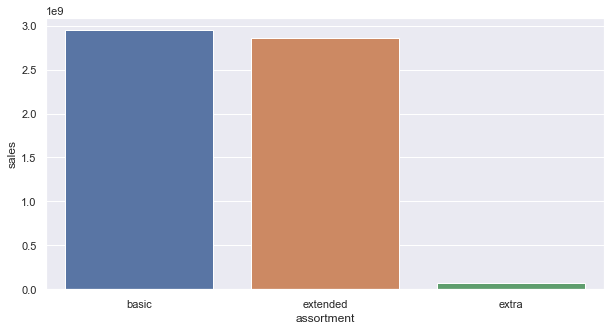

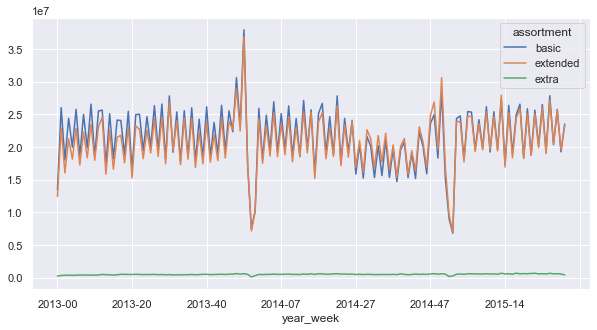

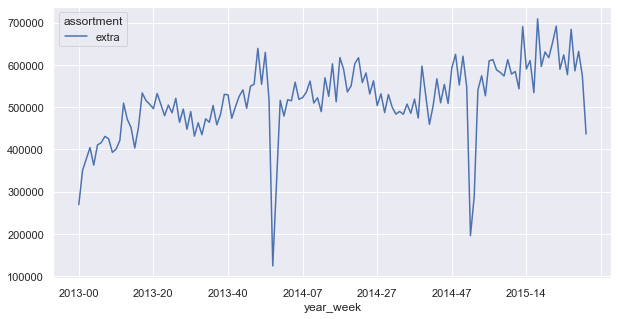

In [30]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
plt.rcParams['figure.figsize'] = [10,5]
sns.barplot(x = 'assortment', y = 'sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### H2. Stores with closer competitors should sell less.
**FALSE**: Stores with closer competitors sell more.

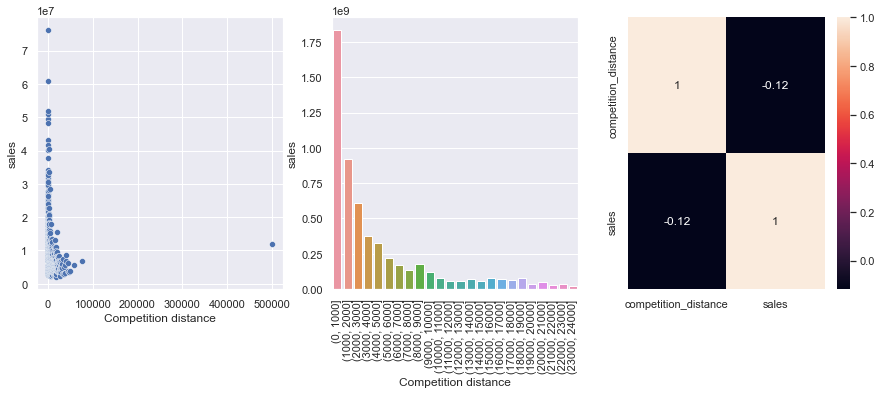

In [31]:
plt.rcParams['figure.figsize'] = [15,5]

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)
plt.xlabel('Competition distance')

plt.subplot(1,3,2)
bins = list(np.arange(0,25000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
aux2 = aux2[aux2['sales'] > 0]

sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation=90)
plt.xlabel('Competition distance')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Stores with competitors for longer time should sell more.
**FALSE**: Stores with competitors for longer time sell less.

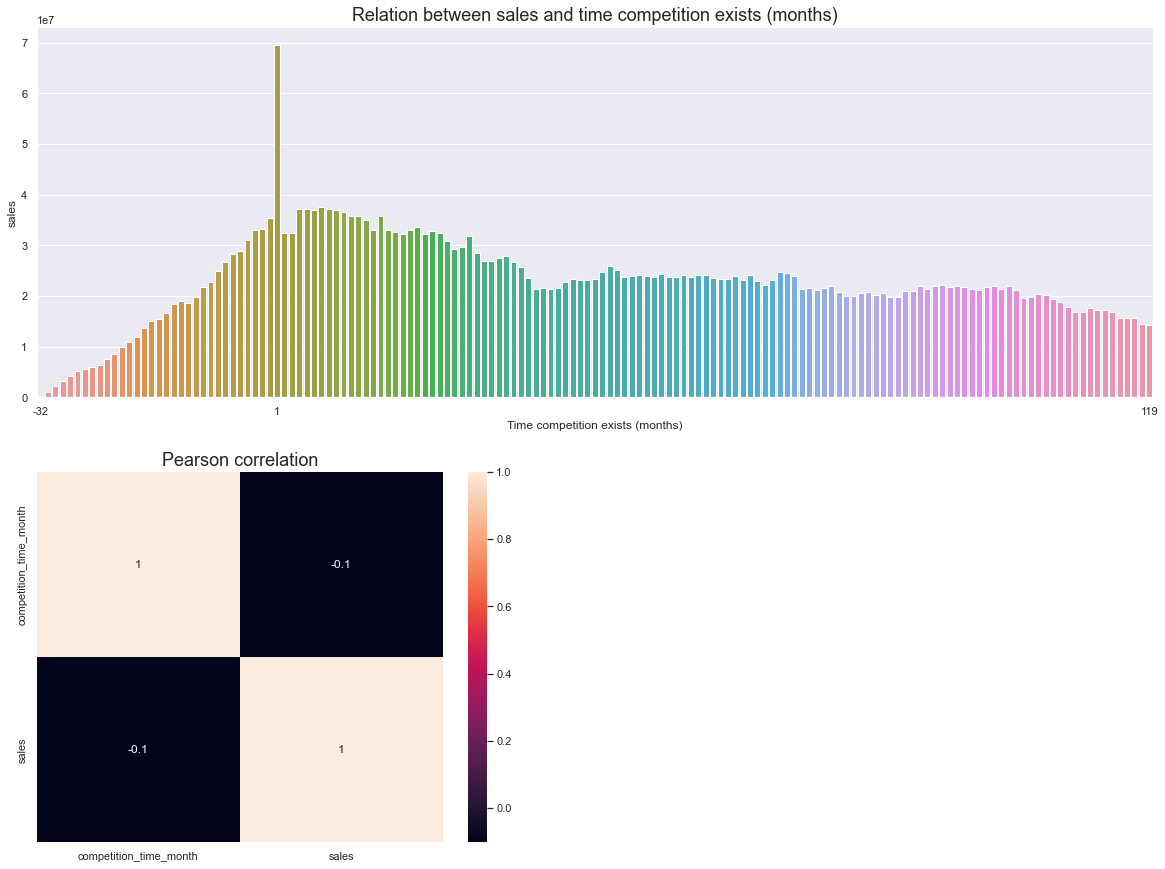

In [32]:
plt.rcParams['figure.figsize'] = [20,15]

plt.subplot(2,1,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks([0,32,150])
plt.xlabel('Time competition exists (months)')
plt.title('Relation between sales and time competition exists (months)', size = 18)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)
plt.title('Pearson correlation', size = 18);

### H4.  Stores with promotions active for longer should sell more.
**FALSE**: Stores sell less after promotions are actived for a long time.

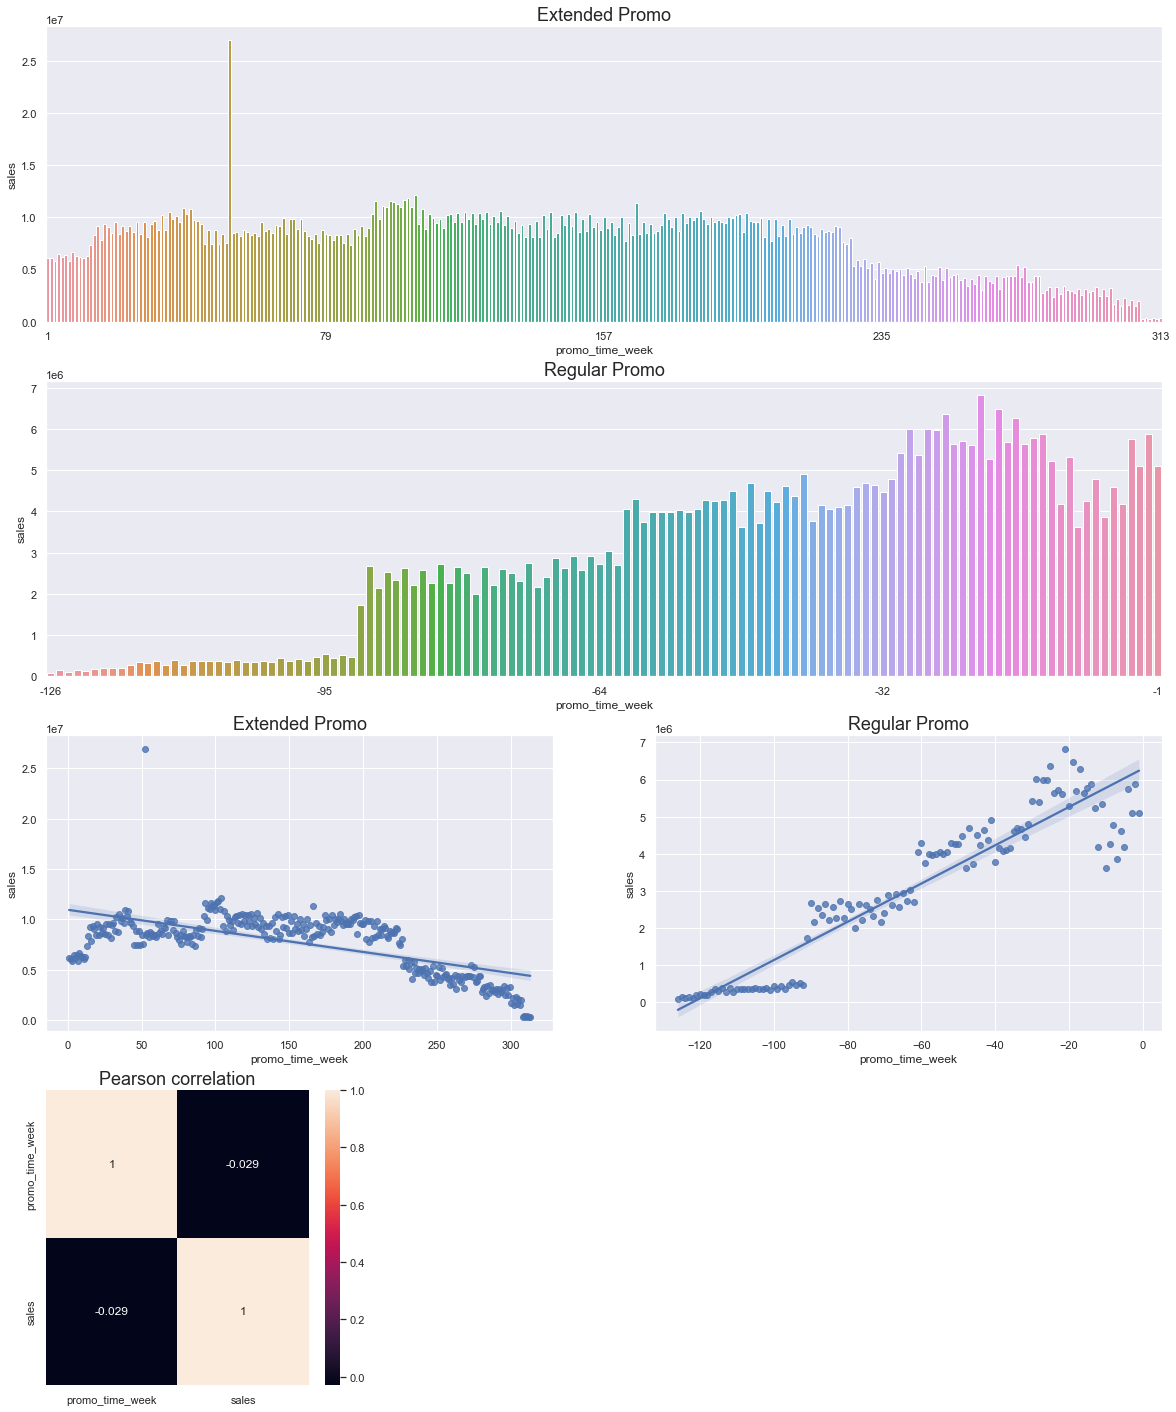

In [33]:
plt.rcParams['figure.figsize'] = [20,25]

aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(4,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] # extended promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.title('Extended Promo', size = 18)
plt.xticks([0,78,156,234,312])

plt.subplot(4,1,2)
aux3 = aux1[aux1['promo_time_week'] < 0] # regular promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.title('Regular Promo', size = 18)
plt.xticks([0,31,62,94,125])

plt.subplot(4,2,5)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.title('Extended Promo', size = 18)

plt.subplot(4,2,6)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.title('Regular Promo', size = 18)

plt.subplot(4,3,10)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)
plt.title('Pearson correlation', size = 18);

### H5. Stores with more days of promotions should sell more.

### H6. Stores with more consecutive promotions should sell more.
**FALSE**: Stores with more consecutive promotions sell less.

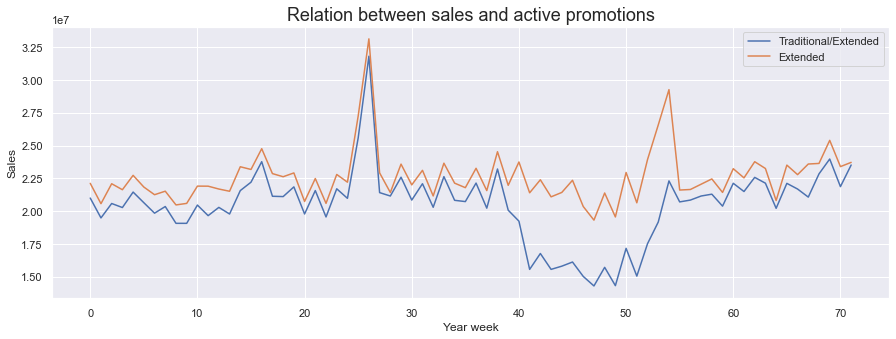

In [34]:
plt.rcParams['figure.figsize'] = [15,5]

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()
ax = aux2.plot(ax = ax)

ax.legend(labels = ['Traditional/Extended', 'Extended'])
plt.title('Relation between sales and active promotions', size = 18)
plt.xlabel('Year week')
plt.ylabel('Sales');

### H7. Stores open on Christmas holiday should sell more.
**FALSE**: Stores open on Christmas holiday sell less than easter or public holidays.

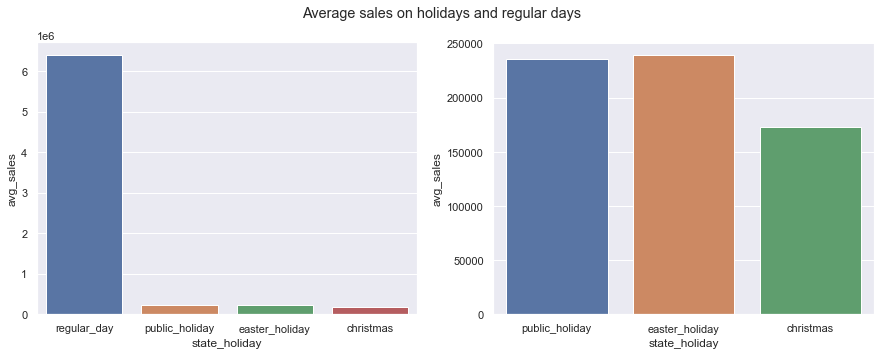

In [35]:
aux = df4[['date','state_holiday','sales']].groupby(['date','state_holiday']).sum().reset_index()
counts = pd.DataFrame(aux['state_holiday'].value_counts()).reset_index().rename(columns={'index':'state_holiday',
                                                                                         'state_holiday':'quantity'})
aux = aux.groupby('state_holiday').sum().reset_index()
counts = counts.merge(aux, on='state_holiday')
counts['avg_sales'] = counts['sales']/counts['quantity']
plt.suptitle('Average sales on holidays and regular days')
plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='avg_sales',data=counts)
plt.subplot(1,2,2)
sns.barplot(x='state_holiday',y='avg_sales',data=counts[counts['state_holiday'] != 'regular_day']);

### H8. Stores should sell more over the time.
**TRUE**: Stores sell more over the time, but the correlation between time and sales is weak.

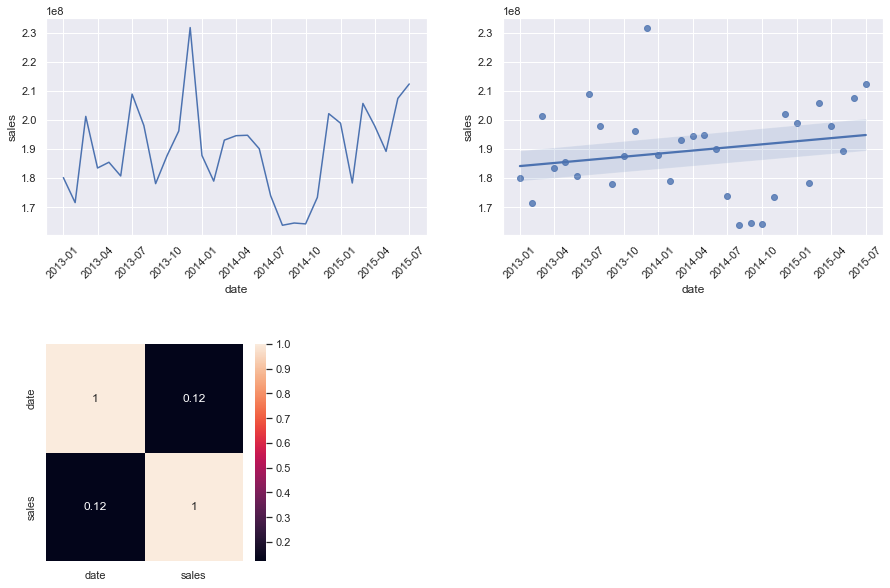

In [24]:
plt.rcParams['figure.figsize'] = [15,10]
aux = pd.DataFrame(df4.groupby([df4.date.dt.year,
                                df4.date.dt.month])['sales'].sum()).rename_axis(['year',
                                                                                 'month']).reset_index()
aux['date'] = aux.apply(lambda x: datetime.datetime(year = x['year'],
                                                    month = x['month'],
                                                    day = 1), axis = 1)

plt.subplot(2, 2, 1)
sns.lineplot(x = 'date', y = 'sales', data = aux)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
aux1 = aux.copy()

# Regplot needs to receive a number instead of date type
aux1['date'] = np.asarray(aux.date).astype(float)
aux1 = aux1[['date','sales']]
sns.regplot(x = 'date', y = 'sales', data = aux1)

# Set labels to the same as the first plot
aux['label'] = aux['date'].dt.strftime('%Y-%m')
plt.xticks(rotation=45)
plt.xticks(aux1['date'][np.arange(0,31,3)],aux['label'][np.arange(0,31,3)])

plt.subplot(2, 3, 4)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

# Adjust space between subplots
plt.subplots_adjust(#left=0.125,
                    #bottom=0.1, 
                    #right=0.9, 
                    #top=0.9, 
                    #wspace=1, 
                    hspace=0.5);

### H9. Stores should sell more in the second half of the year.
**TRUE**: Stores sell more in the second half of the year, but the correlation between month and sales is weak.

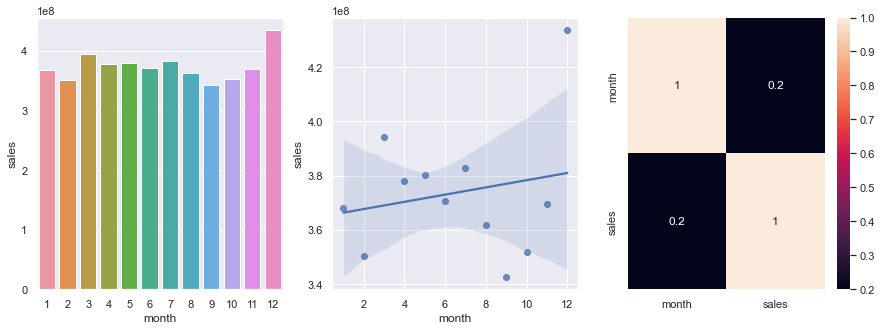

In [37]:
plt.rcParams['figure.figsize'] = [15,5]
aux1 = df4[['month', 'sales']][df4['year'] != 2015].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H10. Stores should sell more after the 10th day of each month.
**FALSE**: Stores sell less after the 10th day of each month, but the correlation between days and sales is weak.

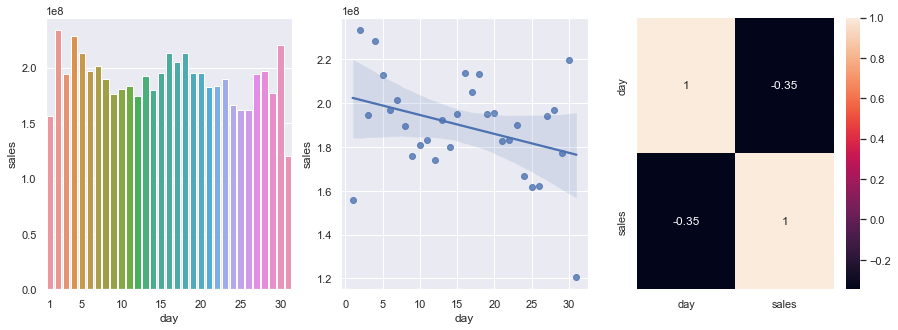

In [38]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)
plt.xticks(np.append(0, np.arange(4,31,5)))

plt.subplot(1, 3, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H11. Stores should sell less on weekends.
**TRUE**: Stores sell less on weekends.

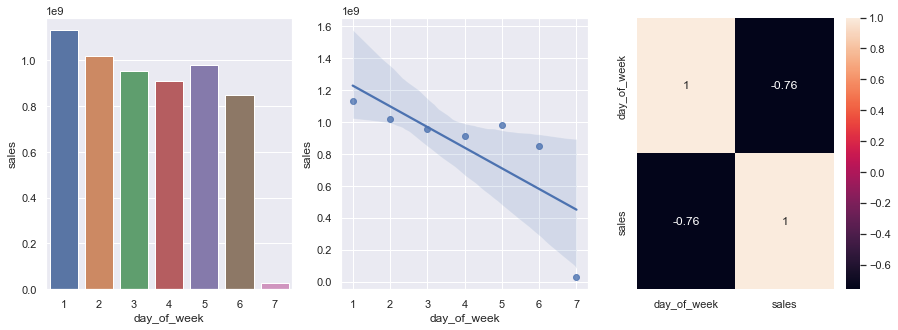

In [39]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H12. Stores should sell less during school holidays.
**TRUE**: Stores sell less during school holidays.

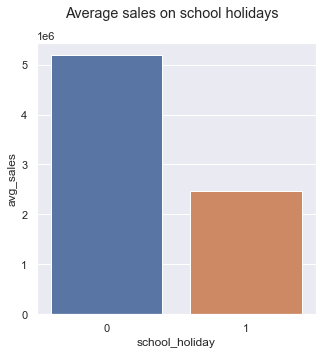

In [40]:
plt.rcParams['figure.figsize'] = [5,5]
aux = df4[['date','school_holiday','sales']].groupby(['date','school_holiday']).sum().reset_index()
counts = pd.DataFrame(aux['school_holiday'].value_counts()).reset_index().rename(columns={'index':'school_holiday',
                                                                                         'school_holiday':'quantity'})
aux = aux.groupby('school_holiday').sum().reset_index()
counts = counts.merge(aux, on='school_holiday')
counts['avg_sales'] = counts['sales']/counts['quantity']
plt.suptitle('Average sales on school holidays')
sns.barplot(x='school_holiday', y='avg_sales', data=counts);

## Multivariate Analysis

### Numerical Variable

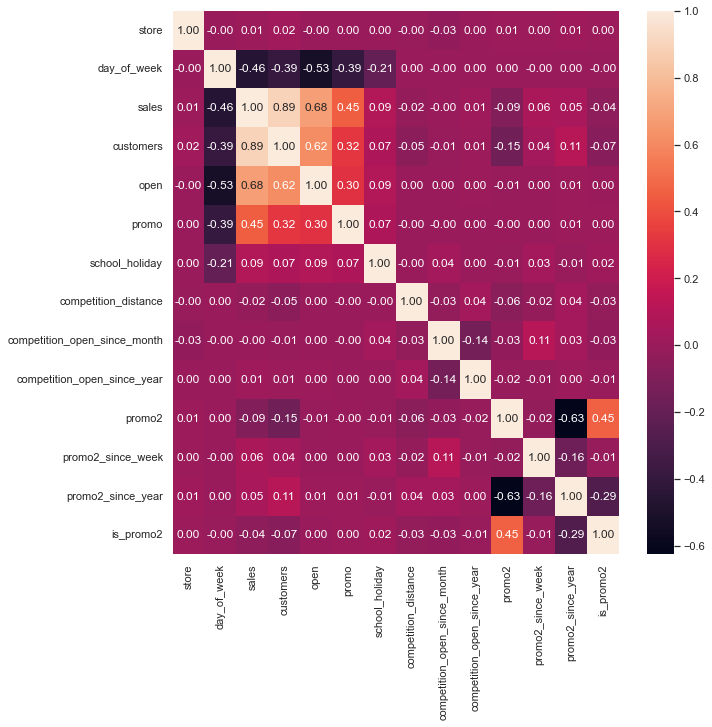

In [41]:
plt.rcParams['figure.figsize'] = [10,10]
corr = num_attributes.corr(method = 'pearson')
sns.heatmap(corr, annot = True, fmt='.2f');

### Categorical Variable

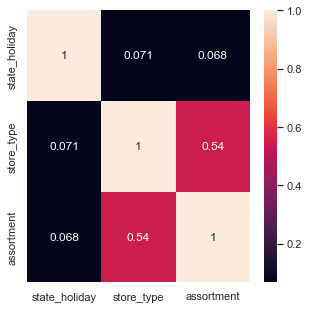

In [79]:
# Categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d = pd.DataFrame({'state_holiday':[a1, a2, a3],
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9]})
d = d.set_index(d.columns)

plt.rcParams['figure.figsize'] = [5,5]
sns.heatmap(d,annot=True);

# Data Preparation

In [25]:
df5 = df4.copy()

## Rescaling

In [26]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
df5['year'] = mms.fit_transform(df5[['year']].values)

## Transformation

### Encoding of Categorical Variables

In [27]:
# One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation

In [28]:
df5['sales'] = np.log1p(df5['sales'])

### Nature Transformation

In [29]:
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# Feature Selection

In [30]:
df6 = df5.copy()

## Split dataframe into training and test dataset

In [31]:
# drop cols that has already been transformed
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

In [32]:
# train
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [102]:
# train and test dataset for Boruta
x_train_n = X_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=0).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### Best Features from Boruta

In [33]:
cols_selected = boruta.support_.tolist()

# selected boruta
x_train_fs = X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns,cols_selected_boruta)

### Manual Features Selection

In [34]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(['date','sales'])

display(cols_selected_boruta)

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [35]:
cols_not_selected_boruta = ['is_promo2',
                            'school_holiday',
                            'state_holiday_christmas',
                            'state_holiday_easter_holiday',
                            'state_holiday_public_holiday',
                            'state_holiday_regular_day',
                            'year']
display(cols_not_selected_boruta)

['is_promo2',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'year']

# Machine Learning Modelling

In [96]:
t_ini = time.time()
print('Início:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Início: 21-03-2023 19:14:08


In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## Average Model

In [98]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,"1,354.80",0.21,"1,835.14"


## Linear Regression Model

In [99]:
# model
lr = LinearRegression()
lr.fit(x_train,y_train)
model_name = 'Linear Regression'

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error(model_name,np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,"1,864.32",0.29,"2,672.15"


### Cross Validation

In [100]:
lr_result_cv = cross_validation(x_training,5,model_name,lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.28 +/- 295.23,0.3 +/- 0.02,2956.58 +/- 467.36


## Linear Regression Regularized Model - Lasso

In [101]:
# model
lrr = Lasso(alpha=0.01)
lrr.fit(x_train,y_train)
model_name = 'Linear Regression - Lasso'

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error(model_name,np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,"1,890.39",0.29,"2,745.23"


### Cross Validation

In [102]:
lrr_result_cv = cross_validation(x_training,5,model_name,lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.98 +/- 341.18,0.29 +/- 0.01,3060.24 +/- 503.67


## Random Forest Regressor

In [103]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=0)
rf.fit(x_train,y_train)
model_name = 'Random Forest Regressor'

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error(model_name,np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.66,0.10,"1,014.21"


### Cross Validation

In [104]:
rf_result_cv = cross_validation(x_training,5,model_name,rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.15 +/- 215.92,0.12 +/- 0.02,1254.86 +/- 316.56


## XGBoost Regressor

In [105]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9)
model_xgb.fit(x_train,y_train)
model_name = "XGBoost Regressor"

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error(model_name, np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,"6,683.54",0.95,"7,330.81"


### Cross Validation

In [106]:
xgb_result_cv = cross_validation(x_training,5,model_name,model_xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


# Compare Models Performance

In [107]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE').reset_index(drop=True)

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.66,0.10,"1,014.21"
1,Average Model,"1,354.80",0.21,"1,835.14"
2,Linear Regression,"1,864.32",0.29,"2,672.15"
3,Linear Regression - Lasso,"1,890.39",0.29,"2,745.23"
4,XGBoost Regressor,"6,683.54",0.95,"7,330.81"


### Cross Validation

In [108]:
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2082.28 +/- 295.23,0.3 +/- 0.02,2956.58 +/- 467.36
0,Linear Regression - Lasso,2116.98 +/- 341.18,0.29 +/- 0.01,3060.24 +/- 503.67
0,Random Forest Regressor,836.15 +/- 215.92,0.12 +/- 0.02,1254.86 +/- 316.56
0,XGBoost Regressor,7049.17 +/- 588.63,0.95 +/- 0.0,7715.17 +/- 689.51


In [109]:
tempo = time.time()-t_ini
horas = '{:02d}'.format(int(tempo//3600))
minutos = '{:02d}'.format(int((tempo%3600)//60))
segundos = '{:02d}'.format(int(tempo%60))

print('Fim:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Tempo de execução: {horas}:{minutos}:{segundos}')

Fim: 21-03-2023 19:44:24
Tempo de execução: 00:30:15


# Hyperparameter Fine Tuning

## Random Search

In [131]:
t_ini = time.time()
print('Início:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Início: 22-03-2023 13:31:09


In [132]:
param = {'n_estimators':[1500,1700,2500,3000,3500],
         'eta':[0.01,0.03],
         'max_depth':[3,5,9],
         'subsample':[0.1,0.5,0.7],
         'colsample_bytree':[0.3,0.7,0.9],
         'min_child_weight':[3,8,15]
        }
MAX_EVAL = 10

In [133]:
final_result = pd.DataFrame()
for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k:random.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective       ='reg:squarederror',
                                 n_estimators    =hp['n_estimators'],
                                 eta             =hp['eta'],
                                 max_depth       =hp['max_depth'],
                                 subsample       =hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    model_name = "XGBoost Regressor"
    
    # performance
    result = cross_validation(x_training,5,model_name,model_xgb)
    final_result = pd.concat([final_result,result])
final_result.reset_index(drop=True)

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, '

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1524.53 +/- 163.26,0.21 +/- 0.01,2205.2 +/- 206.27
1,XGBoost Regressor,819.93 +/- 129.04,0.12 +/- 0.01,1179.92 +/- 185.01
2,XGBoost Regressor,1350.57 +/- 121.94,0.19 +/- 0.01,1940.98 +/- 151.71
3,XGBoost Regressor,973.49 +/- 162.16,0.14 +/- 0.02,1405.71 +/- 224.11
4,XGBoost Regressor,1211.42 +/- 131.49,0.17 +/- 0.01,1746.71 +/- 167.34
5,XGBoost Regressor,1330.94 +/- 140.85,0.18 +/- 0.01,1916.84 +/- 173.21
6,XGBoost Regressor,965.06 +/- 125.36,0.14 +/- 0.01,1378.3 +/- 167.08
7,XGBoost Regressor,1420.6 +/- 141.9,0.2 +/- 0.01,2057.07 +/- 195.62
8,XGBoost Regressor,1526.08 +/- 165.14,0.21 +/- 0.01,2208.74 +/- 210.48
9,XGBoost Regressor,1472.66 +/- 150.62,0.2 +/- 0.01,2133.93 +/- 192.74


In [134]:
tempo = time.time()-t_ini
horas = '{:02d}'.format(int(tempo//3600))
minutos = '{:02d}'.format(int((tempo%3600)//60))
segundos = '{:02d}'.format(int(tempo%60))

print('Fim:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Tempo de execução: {horas}:{minutos}:{segundos}')

Fim: 22-03-2023 22:47:33
Tempo de execução: 09:16:23


## Final Model

In [60]:
t_ini = time.time()
print('Início:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Início: 24-03-2023 13:31:29


In [61]:
param_tuned = {'n_estimators': 3500,
               'eta': 0.01,
               'max_depth': 9,
               'subsample': 0.5,
               'colsample_bytree': 0.9,
               'min_child_weight': 3}

# model
model_xgb_tuned = xgb.XGBRegressor(objective       ='reg:squarederror',
                                   n_estimators    =param_tuned['n_estimators'],
                                   eta             =param_tuned['eta'],
                                   max_depth       =param_tuned['max_depth'],
                                   subsample       =param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'])

# fit
model_xgb_tuned.fit(x_train,y_train)

# predict
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
model_name = "XGBoost Regressor"
xgb_result_tuned = ml_error(model_name,np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,654.16,0.10,958.13


In [62]:
tempo = time.time()-t_ini
horas = '{:02d}'.format(int(tempo//3600))
minutos = '{:02d}'.format(int((tempo%3600)//60))
segundos = '{:02d}'.format(int(tempo%60))

print('Fim:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Tempo de execução: {horas}:{minutos}:{segundos}')

Fim: 24-03-2023 14:13:18
Tempo de execução: 00:41:49


# Error interpretation

In [63]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## Business Performance

In [64]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92 = pd.merge(df91,df9_aux3,how='inner',on='store')

## Total Performance

## Machine Learning Performance

In [65]:
# Save trained model
pickle.dump(model_xgb_tuned,open('model/model_rossmann.pkl','wb'))